In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
import math
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk96j_6ay.xlsx'
data = pd.read_excel(path, date_format=[0])
# İlk 5 Satır
data.head()

DATE_TIME  MAXIMUM_SPEED  MINIMUM_SPEED  AVERAGE_SPEED  \
0 2022-01-01 00:00:00            139              9             63   
1 2022-01-01 01:00:00            138              6             61   
2 2022-01-01 02:00:00            133              7             66   
3 2022-01-01 03:00:00            142              9             66   
4 2022-01-01 04:00:00            118             10             69   

   NUMBER_OF_VEHICLES  
0                 235  
1                 251  
2                 234  
3                 180  
4                 121

In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d')
#İndex'e Alınması
data.index = data.DATE_TIME

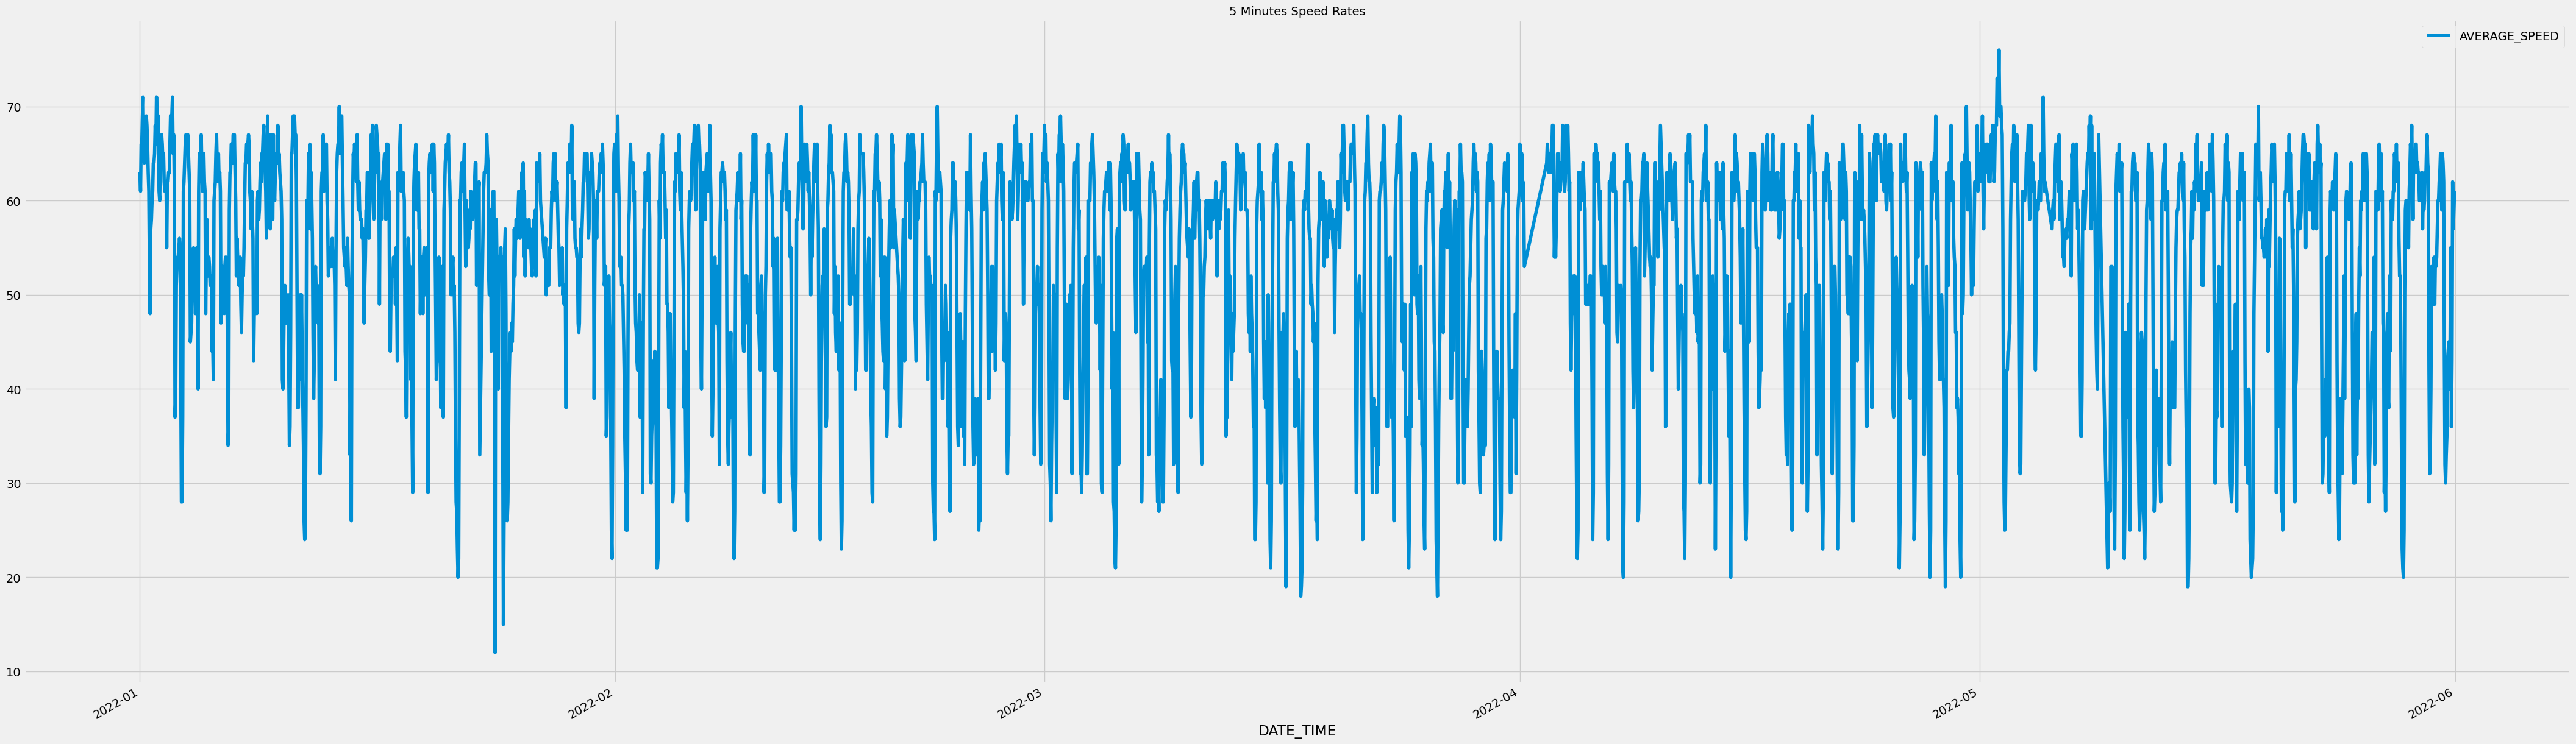

In [4]:
fig = plt.figure(figsize=(48,16))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('5 Minutes Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Seti Sayıları (training set, test set): " + str((len(train), len(test))))
#dataset[train_size:len(dataset)]

Veri Seti Sayıları (training set, test set): (2122, 1415)


In [8]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        for i in range(int((len(dataset) - (window_size + n_steps_out) - 1))):
                a = dataset[i:(i + window_size), 0]
                b = dataset[(i + window_size):(i + window_size) + n_steps_out, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [9]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
train_X, train_Y = create_datasetMultiSteps(train,n_steps_out, window_size)
test_X, test_Y = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(2112, 6)


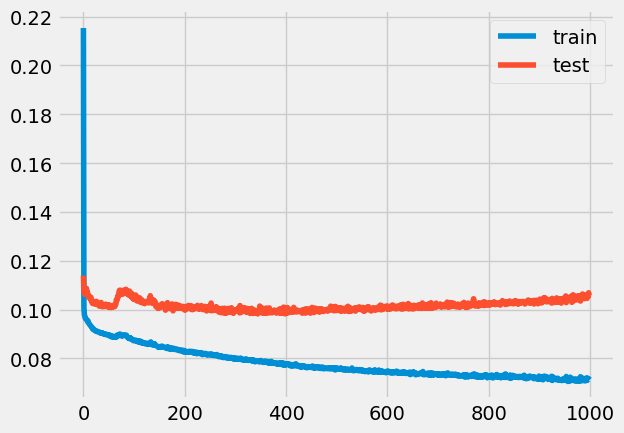

In [10]:
# design network
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = (window_size)))
#model.add(Dropout(0.15))
#model.add(Dense(100, activation='relu' ))
#model.add(Dropout(0.15))
model.add(Dense(80, activation='relu' ))
model.add(Dense(n_steps_out))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=1000, batch_size=32, validation_data=(test_X, test_Y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
y_test = test_Y.reshape(-1,n_steps_out)
#x_test = test_X
y_train = train_Y.reshape(-1,n_steps_out)
#x_train = train_X

In [12]:
# make a prediction
y_train_pred = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], window_size))

# Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
y_train_pred = concatenate((train_X[:, -window_size:], y_train_pred), axis=1)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_pred = y_train_pred[:,-n_steps_out:]

# invert scaling for actual

y_train = concatenate((train_X[:, -window_size:], y_train), axis=1)
y_train = scaler.inverse_transform(y_train)
y_train = y_train[:,-n_steps_out:]

66/66 [==============================] - 0s 2ms/step


In [13]:
# make a prediction
y_test_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], window_size))

# invert scaling for forecast
y_test_pred = concatenate(( test_X[:, -window_size:], y_test_pred), axis=1)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_pred = y_test_pred[:,-n_steps_out:]
# invert scaling for actual
y_test = concatenate((test_X[:, -window_size:], y_test), axis=1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,-n_steps_out:]

44/44 [==============================] - 0s 2ms/step


In [14]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 6.86 RMSE
Test data score: 9.55 RMSE


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(y_test[:,1], y_test_pred[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(y_test[:,2], y_test_pred[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 10.63 MAPE
Test data score: 15.78 MAPE
Test t zamanı score: 11.96 MAPE
Test t+1 zamanı score: 16.64 MAPE
Test t+2 zamanı score: 18.75 MAPE


In [16]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 5.88 MdAPE
Test data score: 8.19 MdAPE


In [17]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 29.91 SMAPE
Test data score: 43.39 SMAPE


In [18]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 1.03 MASE
Test data score: 1.37 MASE


In [19]:
train_y = y_train 
test_y = y_test
pred_train_y = y_train_pred
pred_test_y = y_test_pred

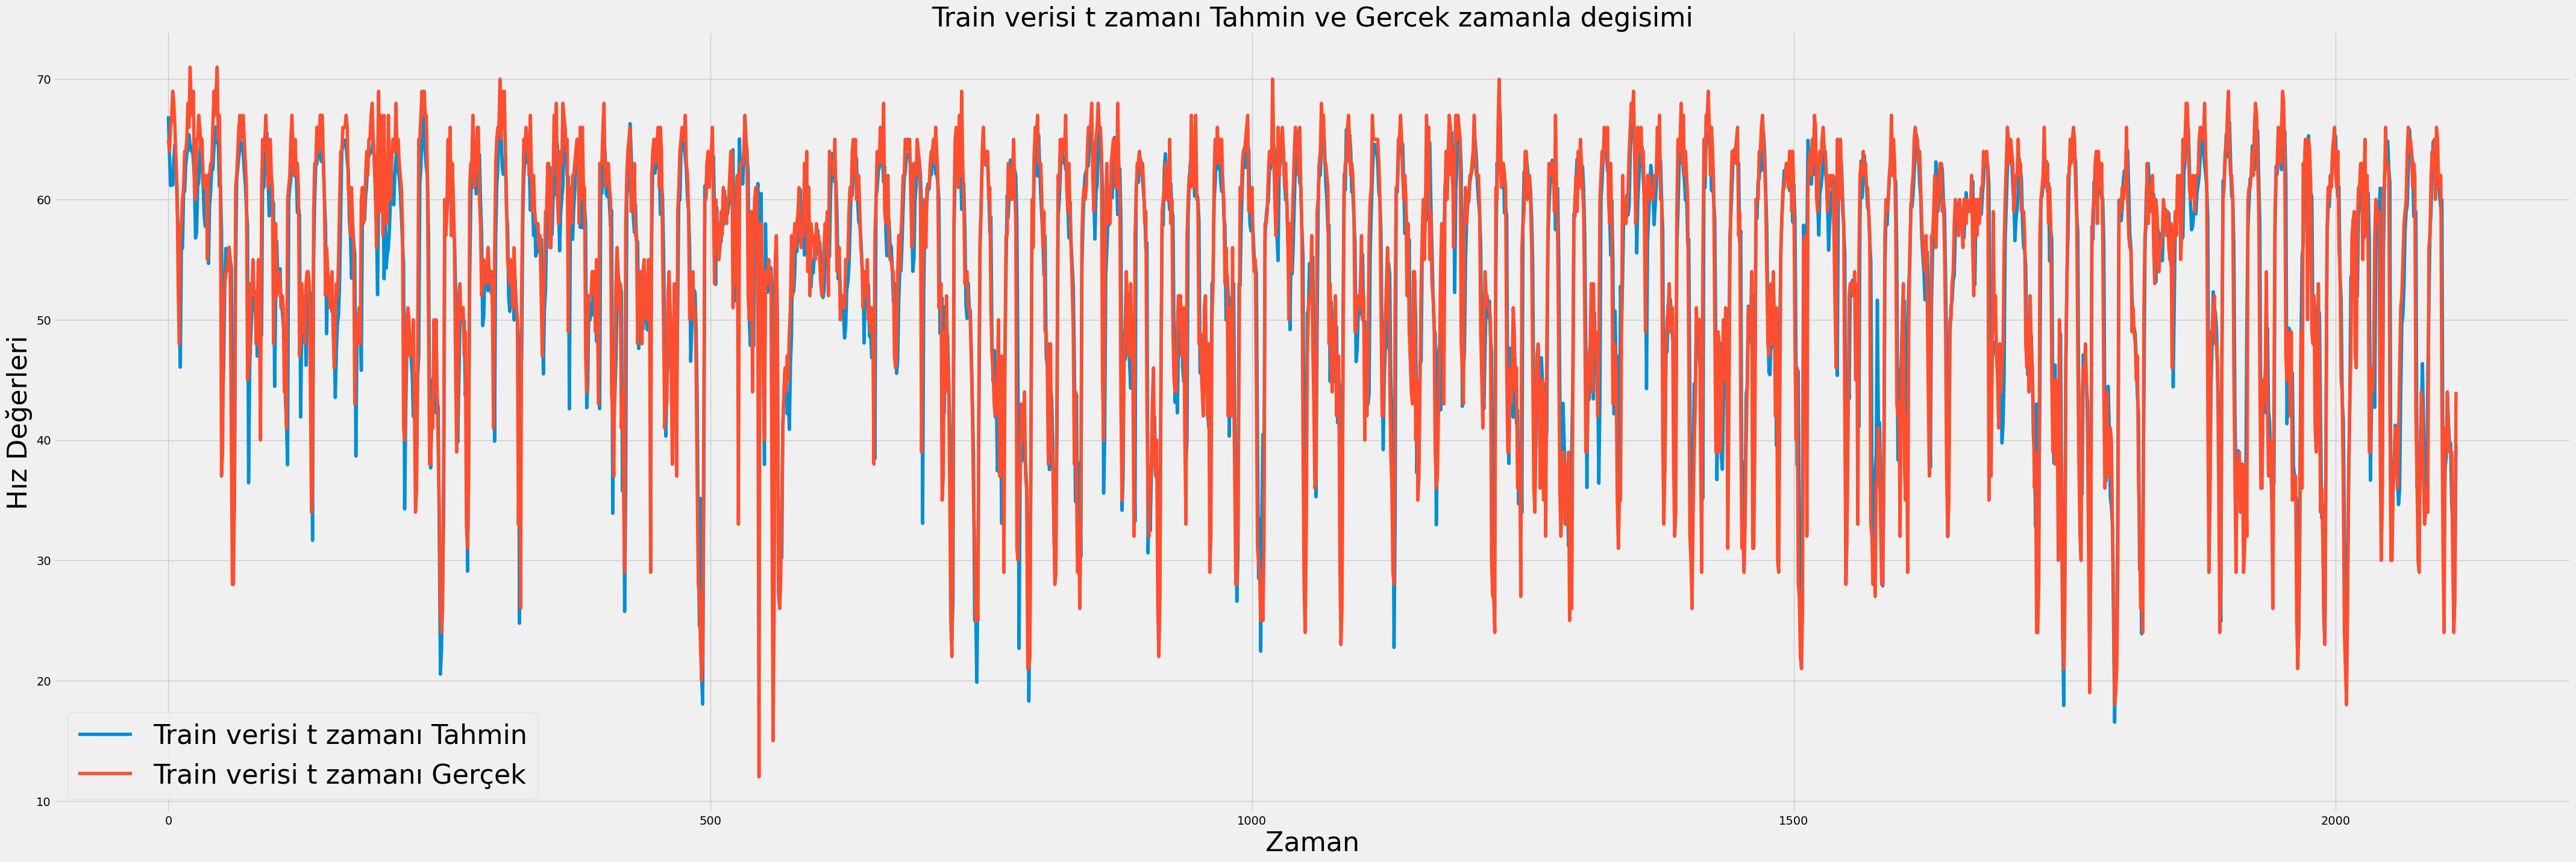

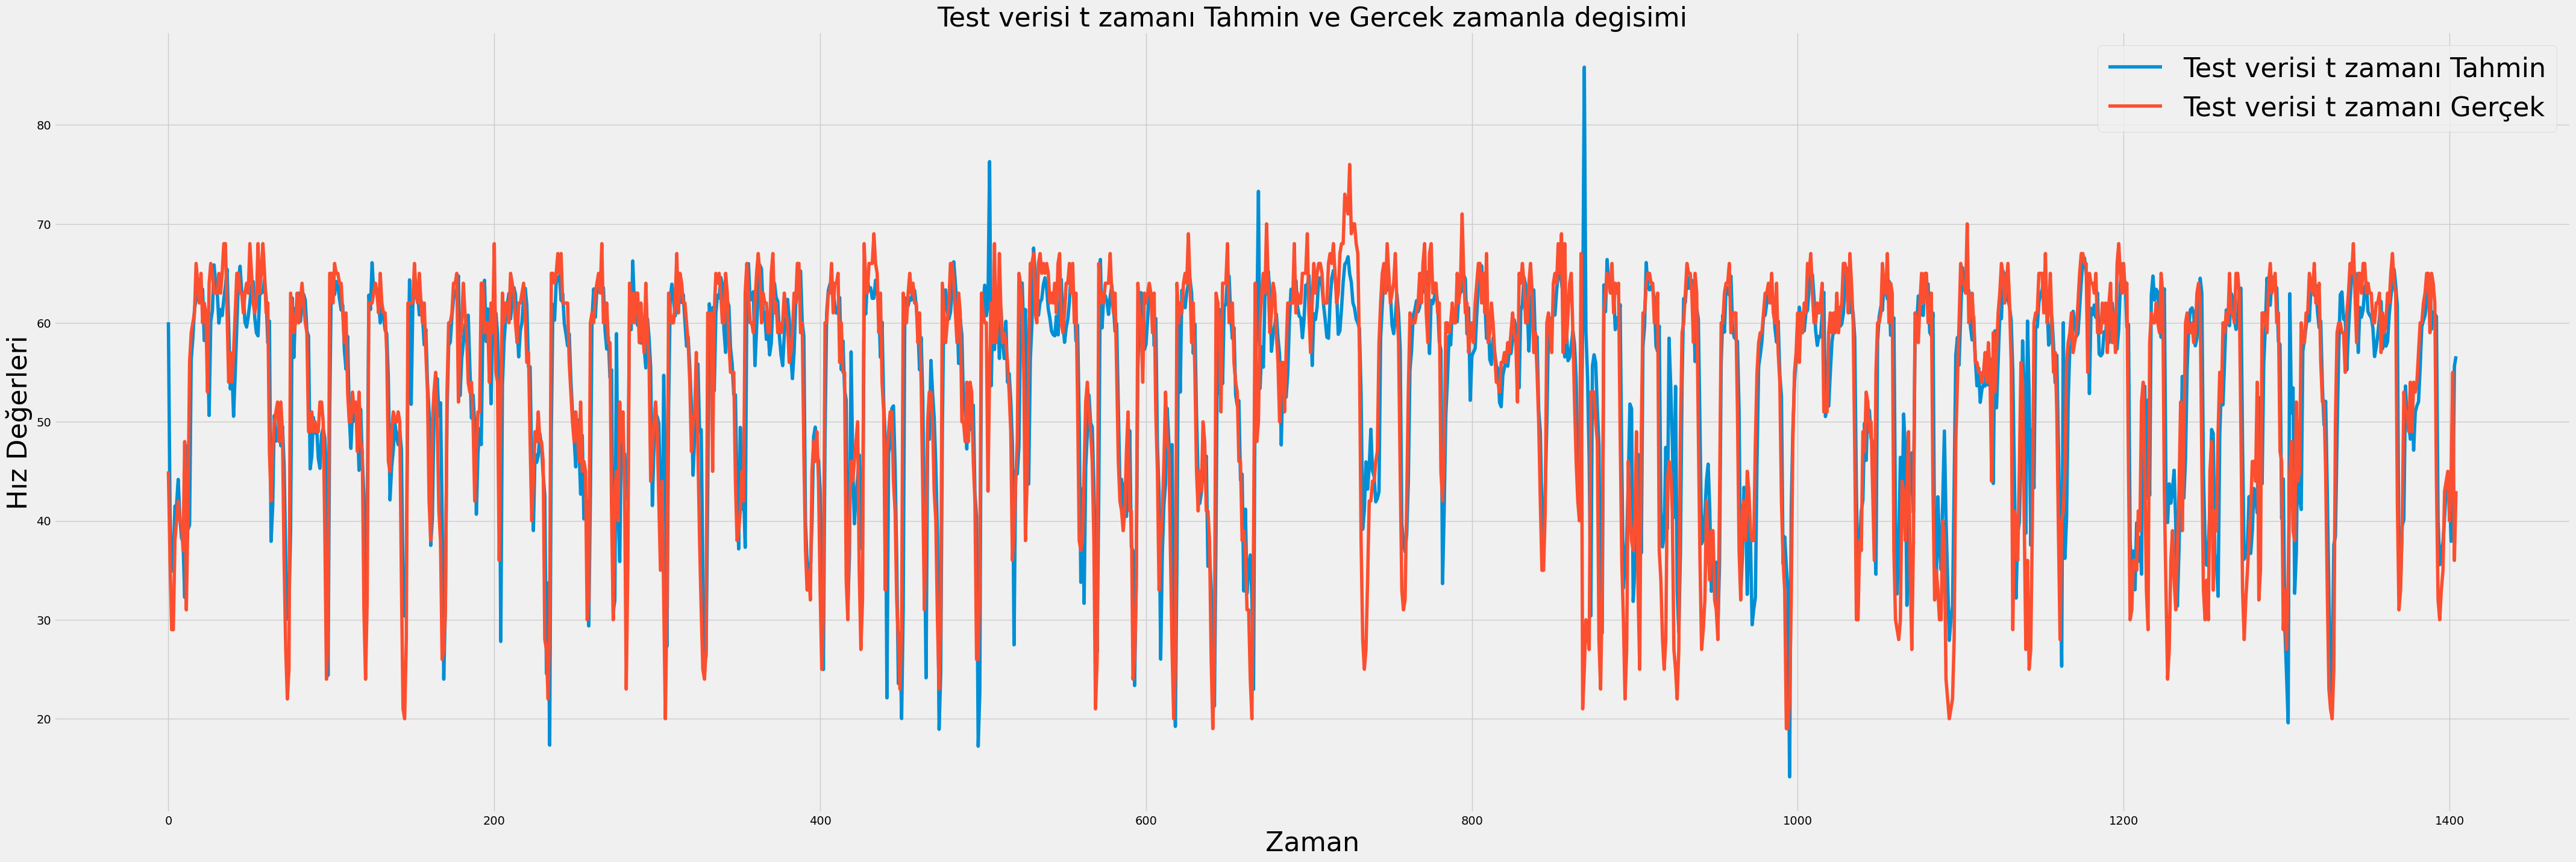

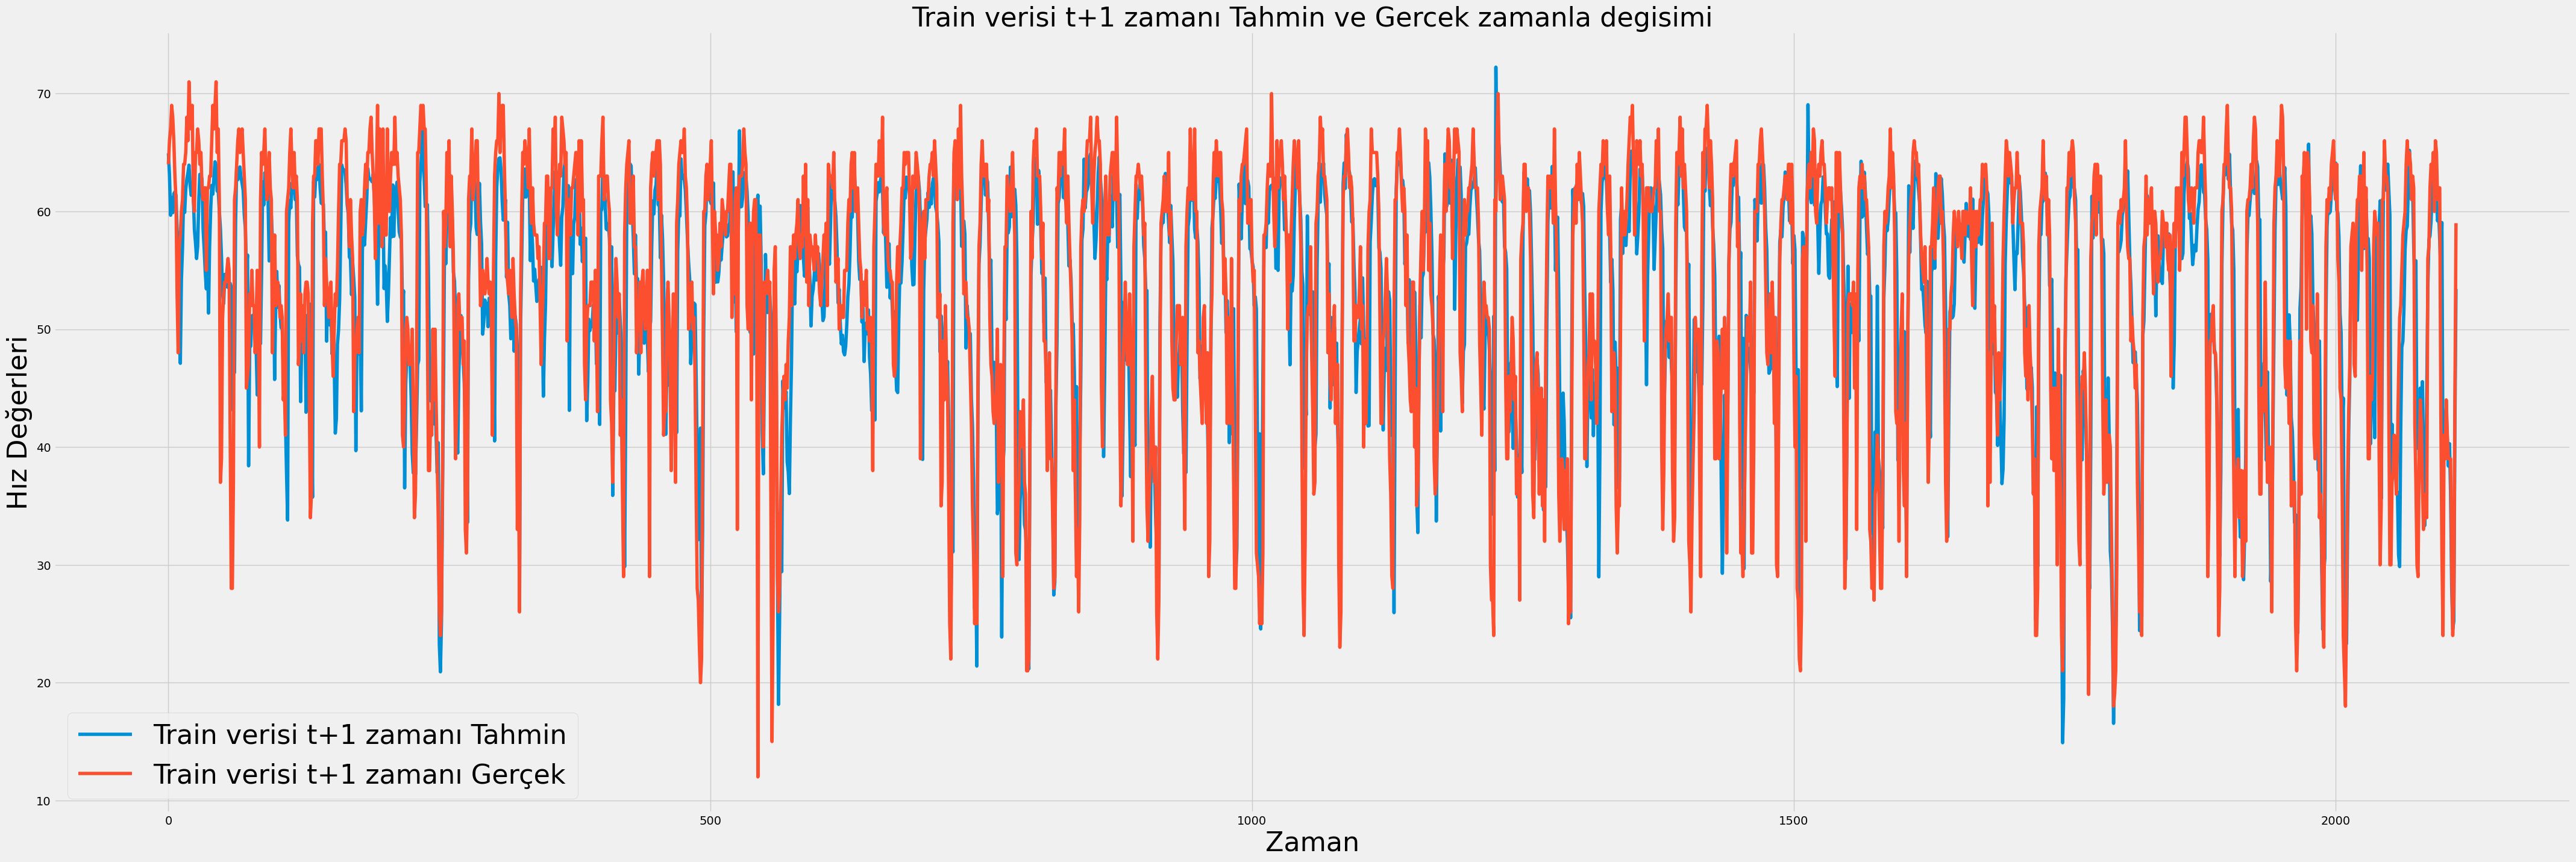

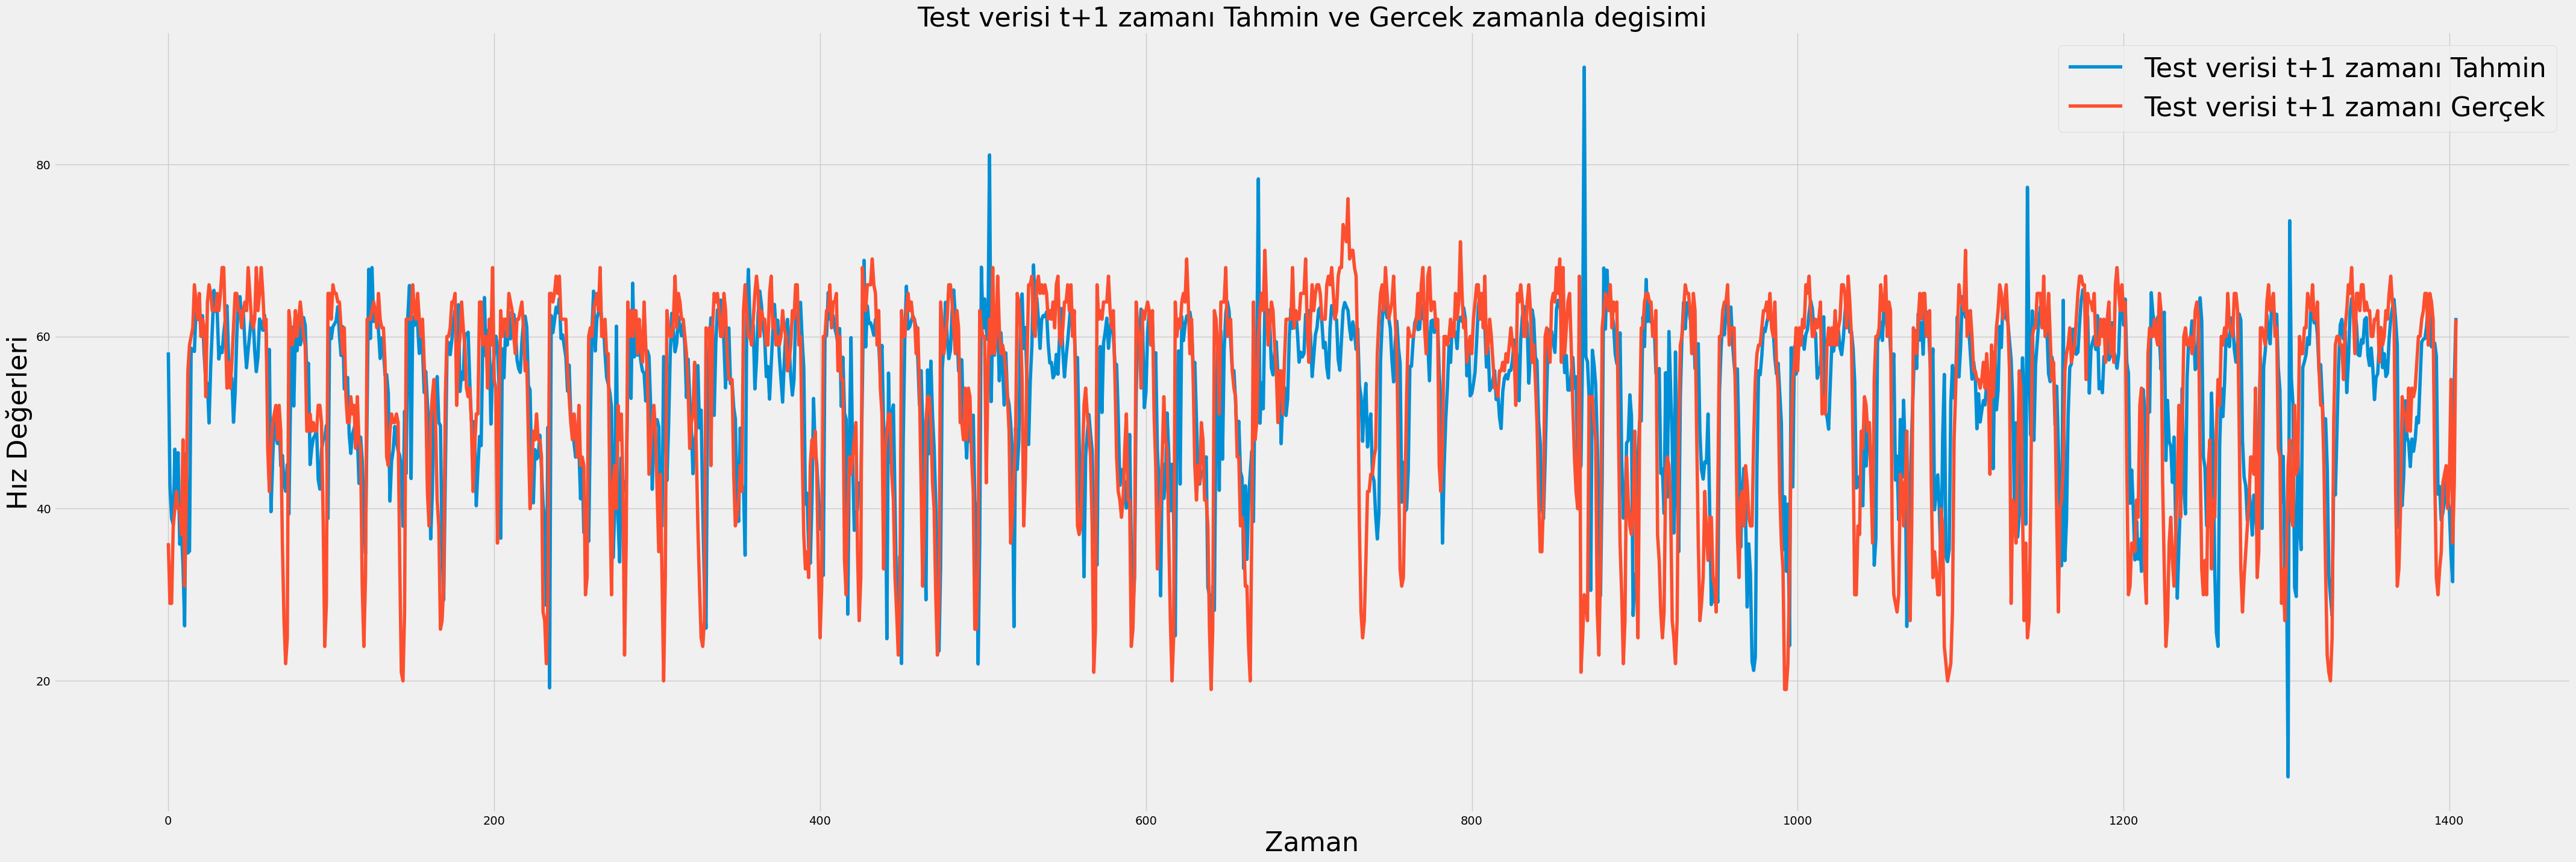

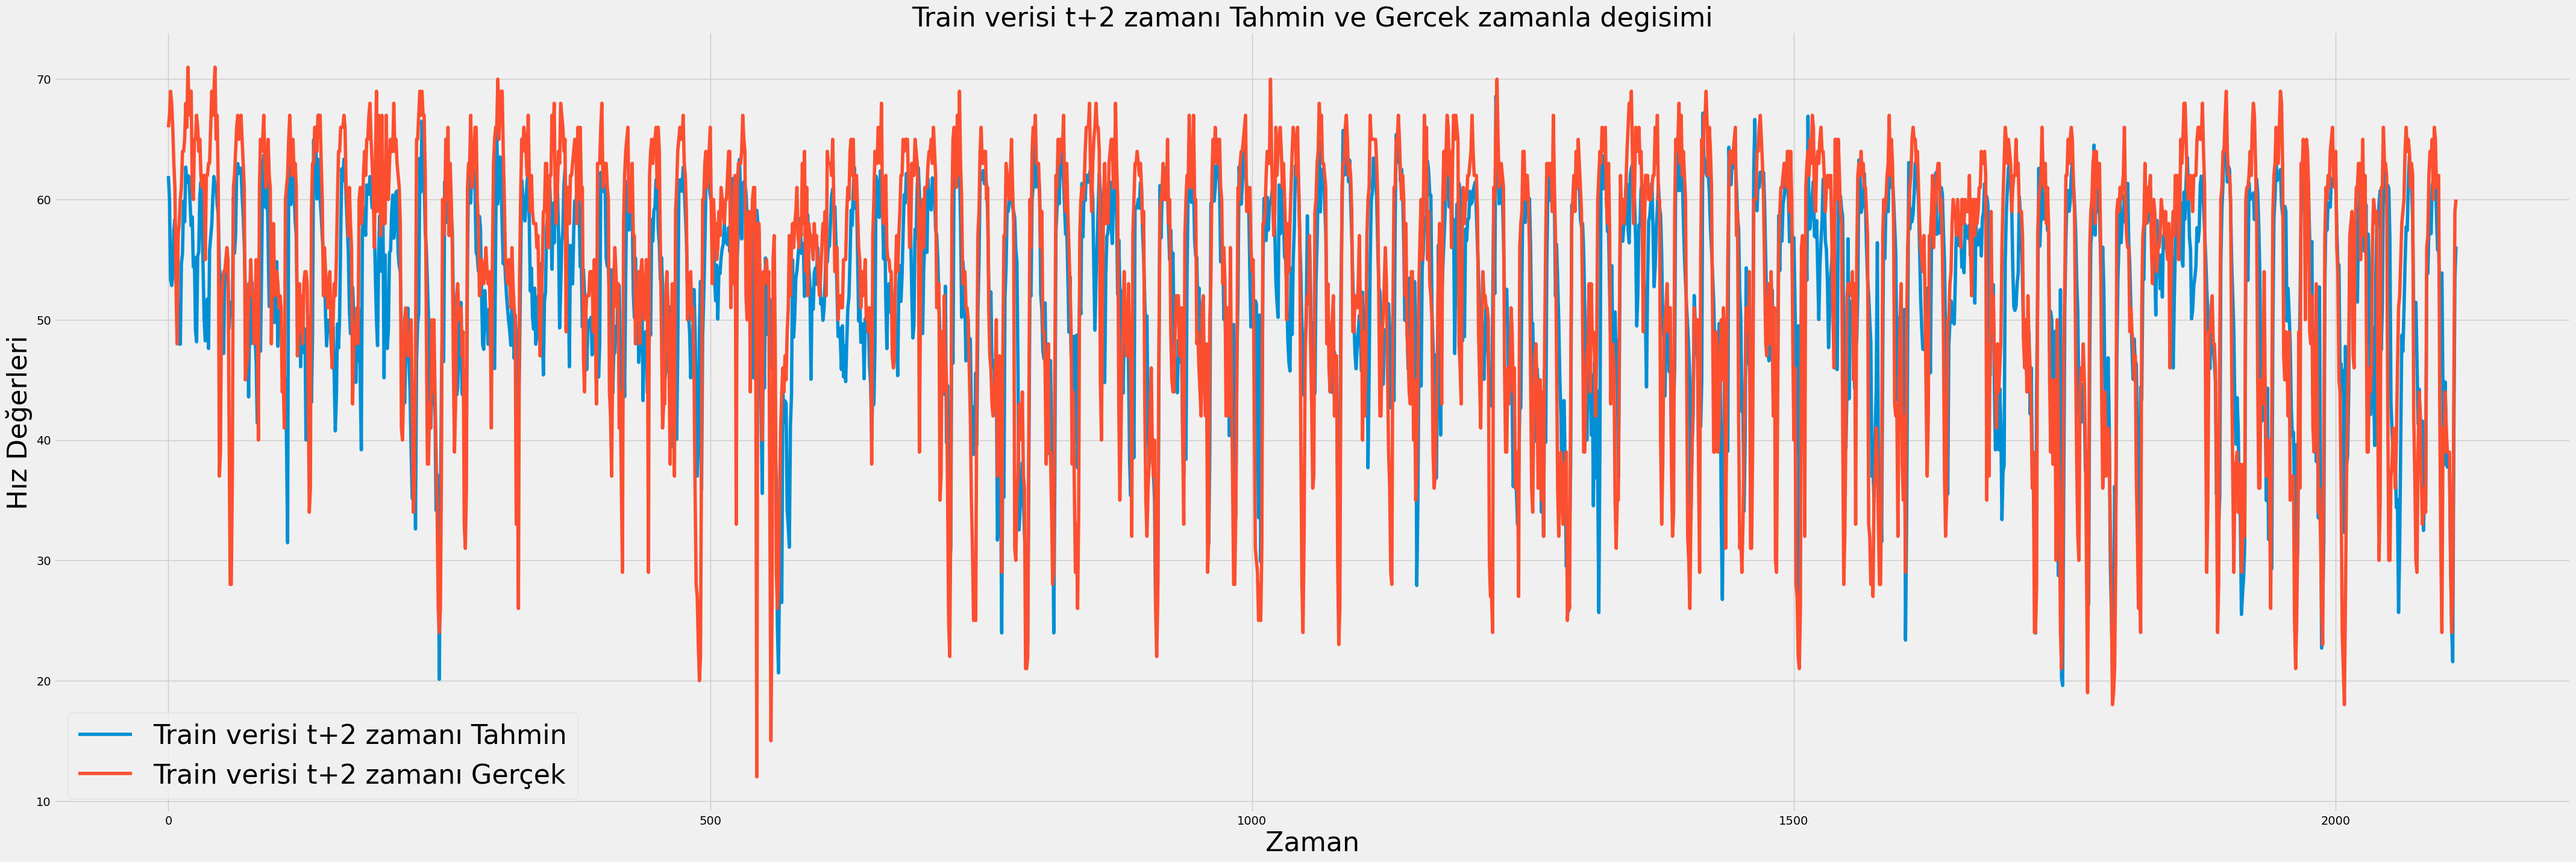

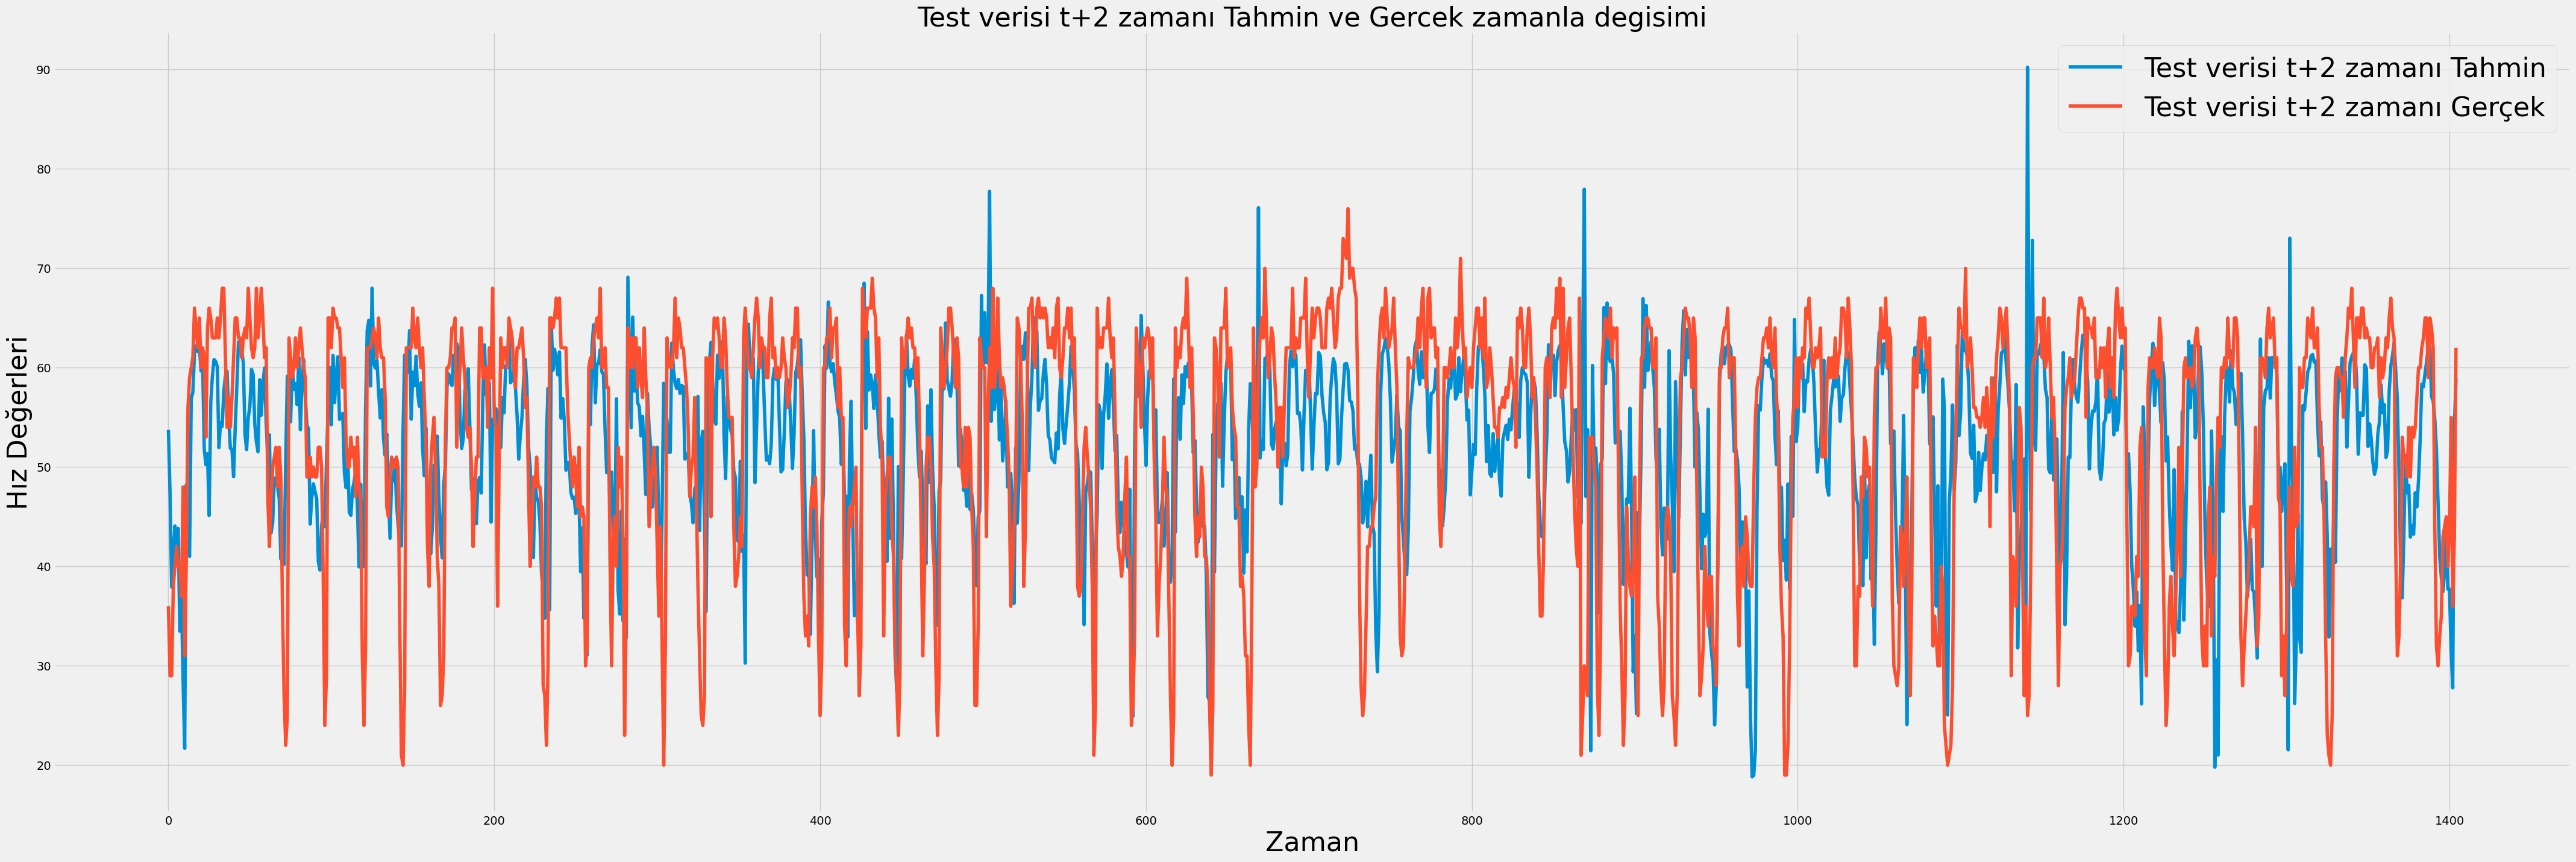

In [20]:
# 10. Test Veri Seti icin Ag sonucu ve verili cikislari cizdiriyoruz

train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y3=test_y[:,2]
pred_test_y2=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')